In [ ]:
# Jupyter Notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import c  # speed of light in m/s

# Display inline plots
%matplotlib inline

In [ ]:
# Simulated subset of SN Ia data (redshift z, distance modulus mu)
data = {
    "z": np.array([0.01, 0.03, 0.05, 0.07, 0.1, 0.12, 0.2, 0.3, 0.4, 0.5]),
    "mu": np.array([32.1, 34.5, 36.1, 37.4, 39.2, 40.1, 42.5, 44.8, 46.3, 47.8])
}
df = pd.DataFrame(data)
df.head()

,z,mu
0,0.01,32.1
1,0.03,34.5
2,0.05,36.1
3,0.07,37.4
4,0.10,39.2


In [ ]:
def mu_to_luminosity_distance(mu):
    return 10 ** ((mu - 25) / 5)  # in Mpc

df["d_L"] = mu_to_luminosity_distance(df["mu"])
df.head()

,z,mu,d_L
0,0.01,32.1,26.302680
1,0.03,34.5,79.432823
2,0.05,36.1,165.958691
3,0.07,37.4,301.995172
4,0.10,39.2,691.830971


In [ ]:
# Only use low-redshift data (z < 0.1) for linear approximation
low_z = df[df["z"] < 0.1]

def hubble_law(z, H0):
    return (c / 1000) * z / H0  # c in km/s

popt, pcov = curve_fit(hubble_law, low_z["z"], low_z["d_L"])
H0_estimate = popt[0]
H0_uncertainty = np.sqrt(np.diag(pcov))[0]

print(f"Estimated Hubble constant H0 ≈ {H0_estimate:.2f} ± {H0_uncertainty:.2f} km/s/Mpc")

Estimated Hubble constant H0 ≈ 78.49 ± 7.33 km/s/Mpc


In [ ]:
H0_s = H0_estimate * 1000 / (3.086e22)  # Convert H0 to 1/s
age_seconds = 1 / H0_s
age_gyr = age_seconds / (60 * 60 * 24 * 365.25 * 1e9)

print(f"Estimated age of the Universe ≈ {age_gyr:.2f} billion years")

Estimated age of the Universe ≈ 12.46 billion years


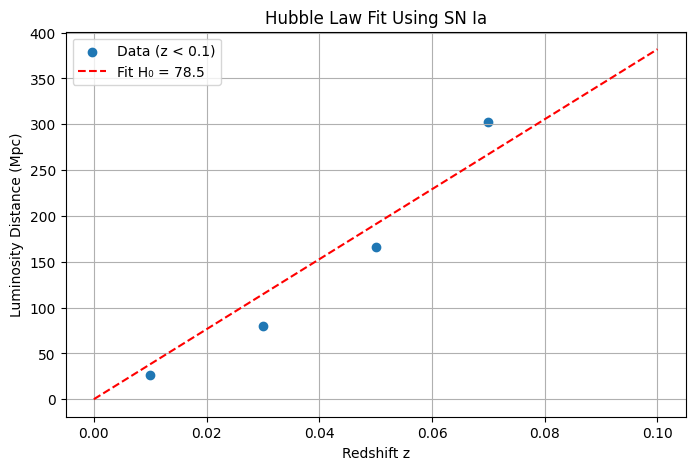

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(low_z["z"], low_z["d_L"], label="Data (z < 0.1)")
z_vals = np.linspace(0, 0.1, 100)
plt.plot(z_vals, hubble_law(z_vals, H0_estimate), 'r--', label=f"Fit H₀ = {H0_estimate:.1f}")
plt.xlabel("Redshift z")
plt.ylabel("Luminosity Distance (Mpc)")
plt.title("Hubble Law Fit Using SN Ia")
plt.legend()
plt.grid(True)
plt.show()

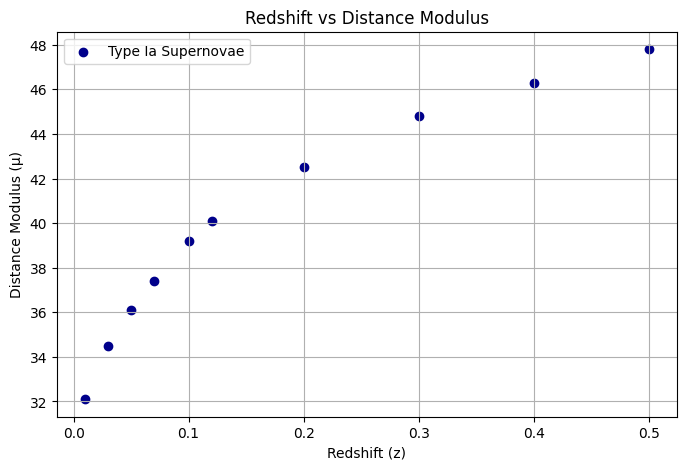

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(df["z"], df["mu"], color="darkblue", label="Type Ia Supernovae")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Redshift vs Distance Modulus")
plt.grid(True)
plt.legend()
plt.show()

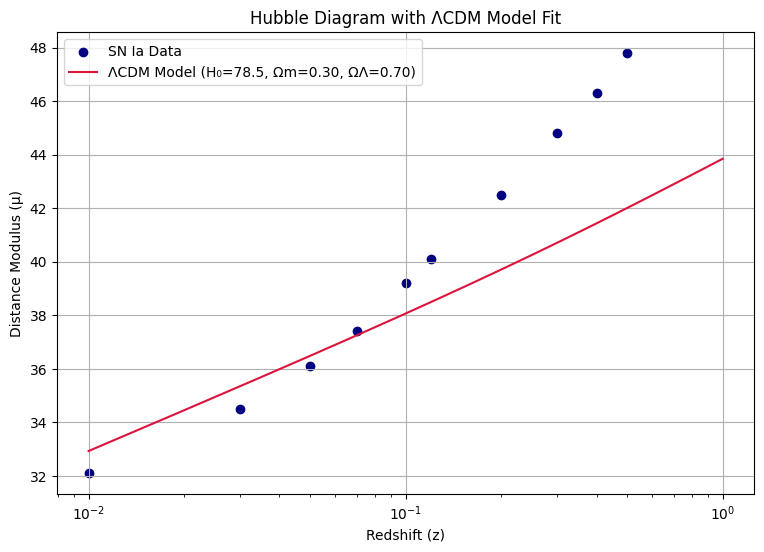

In [ ]:
# Create smooth redshift values for the model curve
z_model = np.linspace(0.01, 1.0, 200)

# Define the function to calculate distance modulus for the Lambda-CDM model
# This requires integrating the inverse of the expansion rate
from scipy.integrate import quad
import numpy as np # Ensure numpy is imported for np.vectorize

def E_inv(z, Omega_m, Omega_lambda):
    # Inverse of the expansion rate E(z) for a flat LCDM model
    # E(z) = sqrt(Omega_m * (1+z)^3 + Omega_lambda)
    return 1.0 / np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

def luminosity_distance_lcdm(z, H0, Omega_m, Omega_lambda):
    # Calculate the comoving distance using numerical integration
    # Dc = c/H0 * integral(E_inv(z'), 0, z)
    # For luminosity distance in Mpc, need c in km/s and H0 in km/s/Mpc
    c_kms = 299792.458 # speed of light in km/s
    # The 'quad' function expects scalar limits, so this function is designed for a single z value.
    integral_result, _ = quad(E_inv, 0, z, args=(Omega_m, Omega_lambda))
    Dc = (c_kms / H0) * integral_result # Comoving distance in Mpc

    # Luminosity distance DL = Dc * (1 + z)
    Dl = Dc * (1 + z)
    return Dl

def model_mu(z, H0, Omega_m, Omega_lambda):
    # Calculate distance modulus from luminosity distance
    # mu = 5 * log10(Dl/10pc) + 25
    # Dl is already in Mpc (1 Mpc = 10^5 pc), so Dl/10pc = Dl * 1e5
    # mu = 5 * log10(Dl * 1e5) + 25
    # mu = 5 * (log10(Dl) + log10(1e5)) + 25
    # mu = 5 * log10(Dl) + 5 * 5 + 25
    # mu = 5 * log10(Dl) + 50
    # Wait, the mu_to_luminosity_distance function implies mu = 5 * log10(dL/10pc) which means dL = 10 * 10^((mu-5)/5) pc or dL = 10^((mu-25)/5) Mpc
    # Let's re-derive: mu = 5 log10(dL / 10pc)
    # where dL is in pc. If dL_Mpc is in Mpc, dL = dL_Mpc * 1e6 pc.
    # mu = 5 log10(dL_Mpc * 1e6 / 10) = 5 log10(dL_Mpc * 1e5) = 5 (log10(dL_Mpc) + log10(1e5)) = 5 log10(dL_Mpc) + 25
    # So mu = 5 * log10(Dl_Mpc) + 25 is correct.

    Dl_Mpc = luminosity_distance_lcdm(z, H0, Omega_m, Omega_lambda)
    # Handle potential log of zero/negative distance if the model or z is bad, though not expected here
    mu = 5 * np.log10(Dl_Mpc) + 25
    return mu

# Define placeholder values for cosmological parameters
# In a real scenario, these would be determined by fitting to the full dataset
H0_model = H0_estimate # You can use the estimated H0 from the linear fit as a starting point
Omega_m = 0.3 # Placeholder value for matter density
Omega_lambda = 0.7 # Placeholder value for dark energy density (assuming flat universe Omega_m + Omega_lambda = 1)

# Use np.vectorize to apply model_mu to each element of z_model
# This makes model_mu callable with an array argument
vectorized_model_mu = np.vectorize(model_mu)

# Now call the vectorized function with the z_model array
mu_model = vectorized_model_mu(z_model, H0_model, Omega_m, Omega_lambda)

# Plot
import matplotlib.pyplot as plt # Ensure matplotlib is imported
plt.figure(figsize=(9, 6))
plt.scatter(df["z"], df["mu"], color='navy', label='SN Ia Data')
plt.plot(z_model, mu_model, color='crimson', label=f'ΛCDM Model (H₀={H0_model:.1f}, Ωm={Omega_m:.2f}, ΩΛ={Omega_lambda:.2f})') # Updated label
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Hubble Diagram with ΛCDM Model Fit")
plt.grid(True)
plt.legend()
plt.xscale('log')  # Optional: use log scale for redshift
plt.show()

In [ ]:
# Compute model μ at data redshift points
# Use the vectorized version of model_mu to apply it to the df["z"] Series
df["mu_model"] = vectorized_model_mu(df["z"], H0_model, Omega_m, Omega_lambda)

# Calculate residuals: observed - model
df["residual"] = df["mu"] - df["mu_model"]
df.head()

,z,mu,d_L,mu_model,residual
0,0.01,32.1,26.302680,32.926725,-0.826725
1,0.03,34.5,79.432823,35.345012,-0.845012
2,0.05,36.1,165.958691,36.485997,-0.385997
3,0.07,37.4,301.995172,37.247472,0.152528
4,0.10,39.2,691.830971,38.066611,1.133389


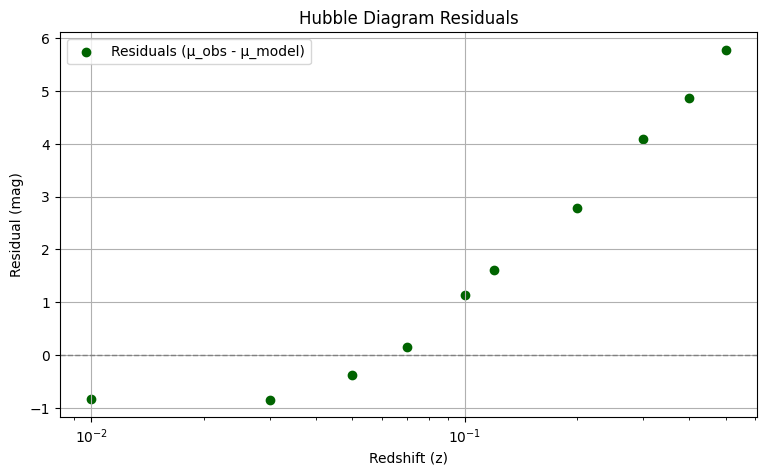

In [ ]:
plt.figure(figsize=(9, 5))
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.scatter(df["z"], df["residual"], color='darkgreen', label='Residuals (μ_obs - μ_model)')
plt.xlabel("Redshift (z)")
plt.ylabel("Residual (mag)")
plt.title("Hubble Diagram Residuals")
plt.grid(True)
plt.legend()
plt.xscale("log")  # Optional: log scale for redshift
plt.show()